In [167]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [168]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
# Read the data
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.isnull().sum())
display(train_data.shape)



Date         0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR           0
ss           0
ff_x         1
ddd_x       27
ff_avg       0
ddd_car    421
rad(m)       0
dtype: int64

(706, 12)

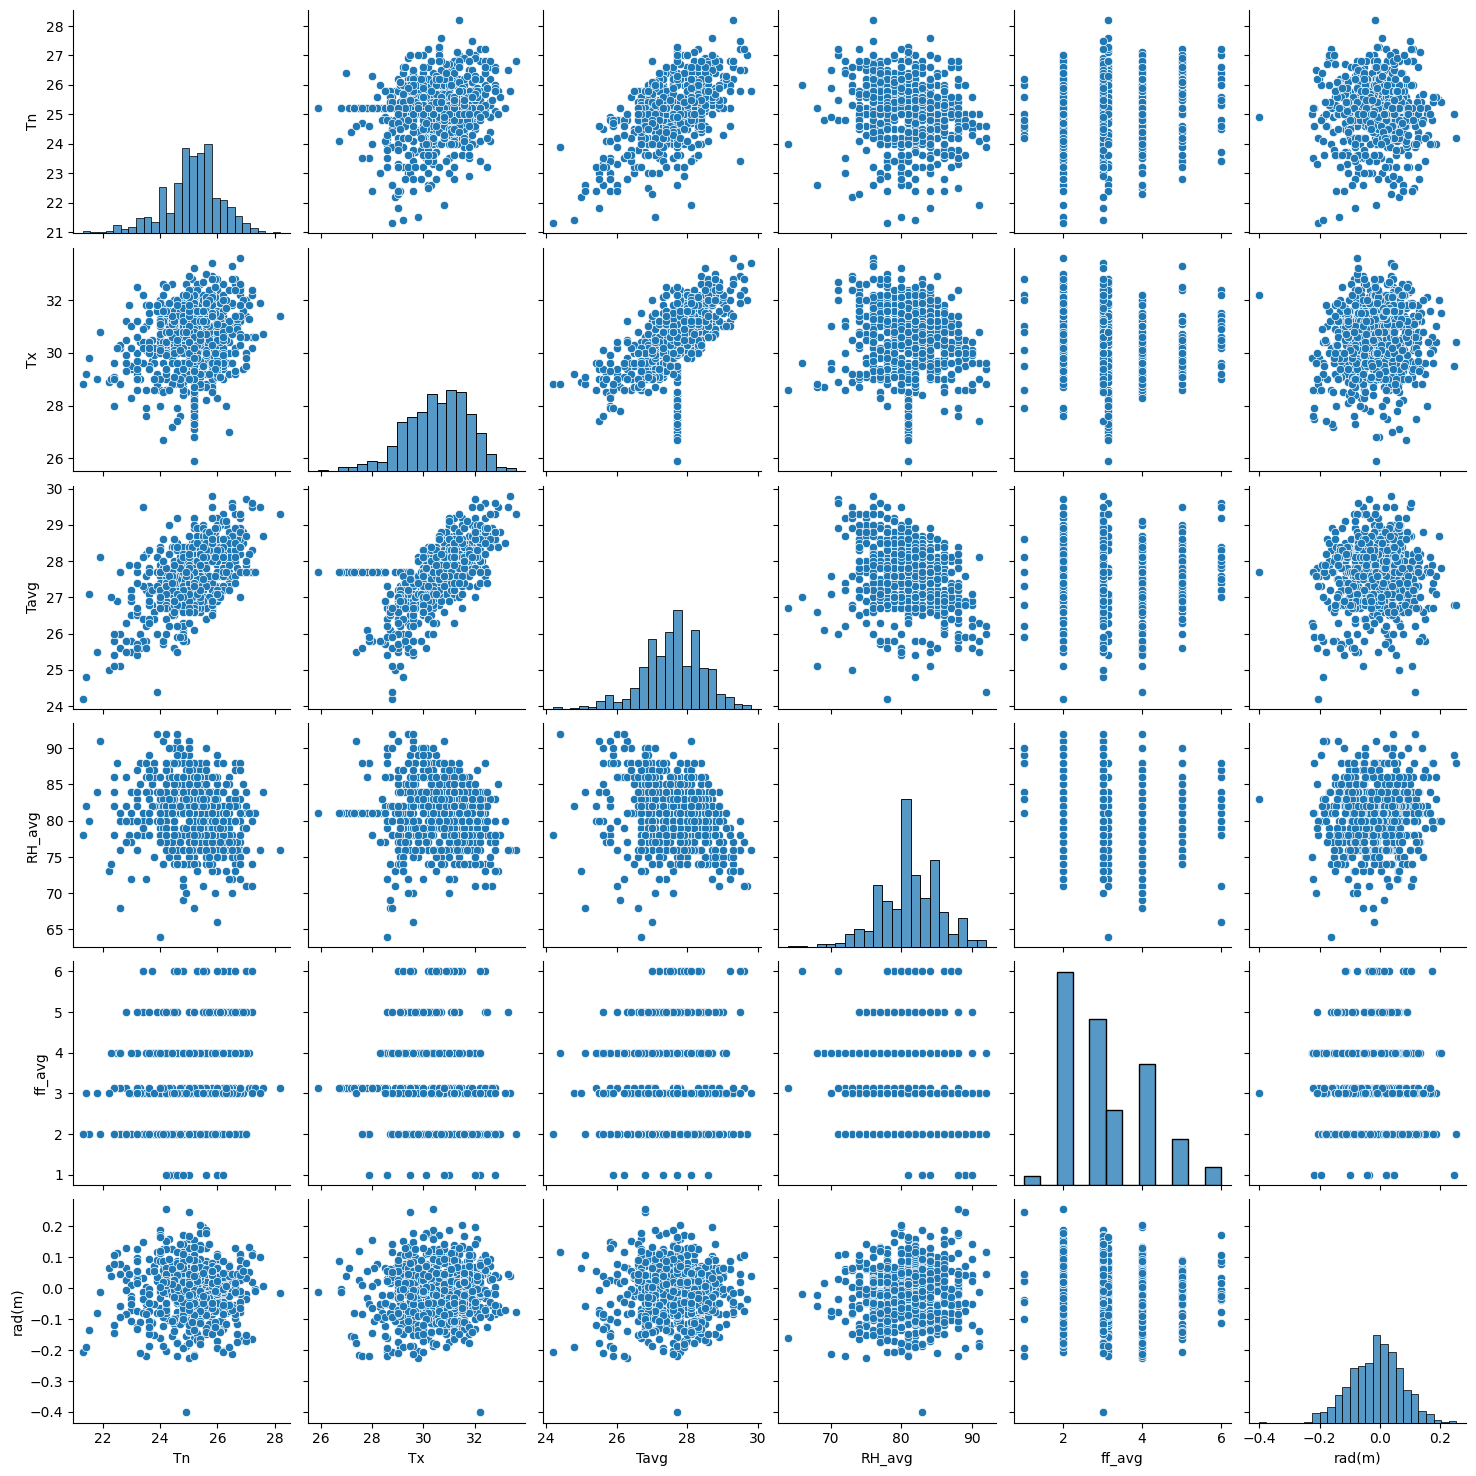

In [169]:
# Pair plot to visualize relationships between features
sns.pairplot(train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']])
plt.show()

Correlation Matrix

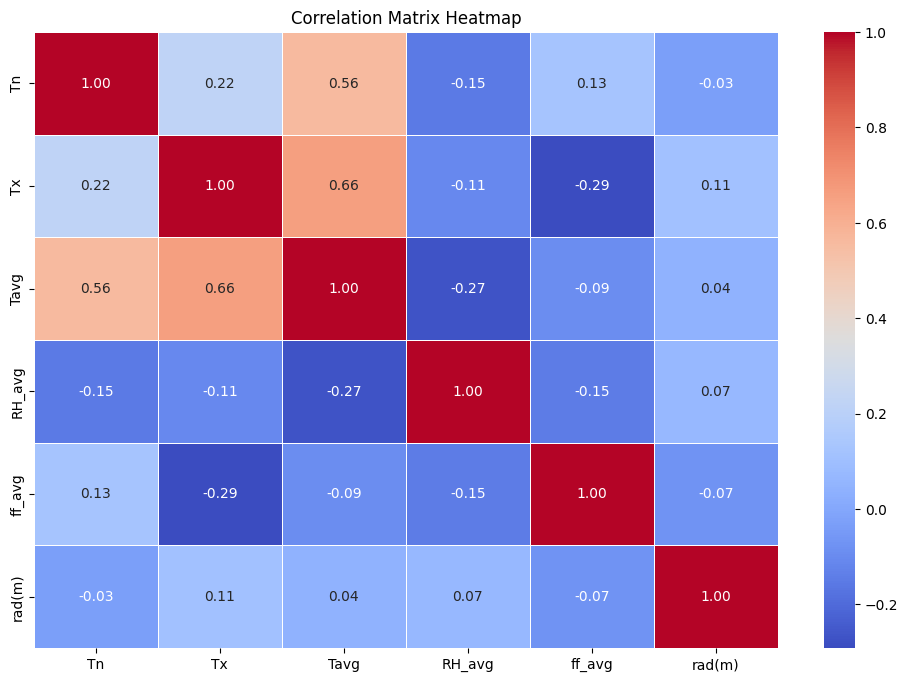

In [170]:
# Calculate the correlation matrix
correlation_matrix = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']].corr()

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

Linear Regression Process Start Here


In [171]:
# Custom Accuracy Metric for Regression: Predictions within a tolerance range
class RegressionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, tolerance, name="regression_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.correct_predictions = self.add_weight(name="correct_predictions", initializer="zeros")
        self.total_predictions = self.add_weight(name="total_predictions", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        within_tolerance = tf.cast(error <= self.tolerance, tf.float32)
        self.correct_predictions.assign_add(tf.reduce_sum(within_tolerance))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)
        
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [172]:
# # Load your training data
# # X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'ss', 'ddd_x', 'RR', 'ff_x']]  # Add more features if needed
# X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']]
# y = train_data['rad(m)']


# # Membagi data menjadi data training dan testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalisasi fitur menggunakan StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Membangun model neural network
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Layer pertama dengan 64 neuron
# model.add(Dense(32, activation='relu'))  # Layer kedua dengan 32 neuron
# model.add(Dense(1))  # Layer output (1 output karena regresi)

# # Menyusun model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', RegressionAccuracy(tolerance=0.05)])

# # Melatih model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# results = pd.DataFrame(history.history)
# results[['loss', 'val_loss']].plot()

# # Evaluasi model
# y_pred = model.predict(X_test)


# # Evaluate the model performance
# results = model.evaluate(X_test, y_test, verbose=0)

# # Display the results
# final_loss, final_mae, final_accuracy = results

# print(f"Final Loss: {final_loss:.4f}")
# print(f"Final MAE: {final_mae:.4f}")
# print(f"Final Accuracy: {final_accuracy:.4f}")

# # Plot predictions vs actual values
# y_pred = model.predict(X_test).flatten()
# plt.plot(y_test.values, label="True")
# plt.plot(y_pred, label="Predicted")
# plt.legend()
# plt.title("Predicted vs Actual rad(m)")
# plt.show()


# # Hitung metrik evaluasi
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R2 Score: {r2}")

In [173]:
# Load your training data
# X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'ss', 'ddd_x', 'RR', 'ff_x']]  # Add more features if needed
X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']]
y = train_data['rad(m)']
# Display the amount of training and testing data
print(f"Amount of X: {len(X)}")
print(f"Amount of y: {len(y)}")
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (Important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)        # Apply the transformation on test set

# Display the amount of training and testing data
print(f"Amount of X_train_scaled: {len(X_train_scaled)}")
print(f"Amount of X_test_scaled: {len(X_test_scaled)}")


# Resample data dengan mengambil sampel acak dari data pelatihan
X_train, y_train = resample(X, y, n_samples=int(len(X)*2), random_state=42)
print(f"Amount of X_train after resampling: {len(X_train)}")
print(f"Amount of y_train after resampling: {len(y_train)}")


X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Amount of X_train after splitting: {len(X_train)}")
print(f"Amount of X_test after splitting: {len(X_test)}")

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization to stabilize training
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)  # Output layer for prediction
])


Amount of X: 706
Amount of y: 706
Amount of X_train_scaled: 564
Amount of X_test_scaled: 142
Amount of X_train after resampling: 1412
Amount of y_train after resampling: 1412
Amount of X_train after splitting: 1129
Amount of X_test after splitting: 283


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4993 - mae: 0.5395 - regression_accuracy: 0.0691 - val_loss: 1.3276 - val_mae: 1.1459 - val_regression_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1529 - mae: 0.3076 - regression_accuracy: 0.0991 - val_loss: 0.0265 - val_mae: 0.1350 - val_regression_accuracy: 0.2120 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0919 - mae: 0.2395 - regression_accuracy: 0.1260 - val_loss: 0.4939 - val_mae: 0.6556 - val_regression_accuracy: 0.0141 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730 - mae: 0.2052 - regression_accuracy: 0.1562 - val_loss: 0.0354 - val_mae: 0.1550 - val_regression_accuracy: 0.1802 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0544 - mae: 0.1842 - regression_accuracy: 0.1870 - val_loss: 0.0233 - val_mae: 0.1227 - val_regression_accuracy: 0.

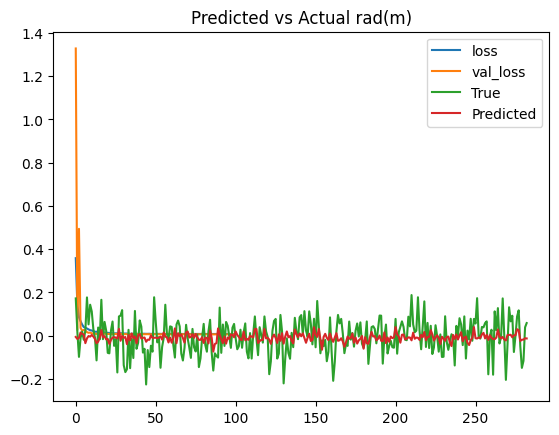

Mean Squared Error: 0.006131458656924643
R2 Score: 0.08105012674691647
Model has been saved successfully!


In [174]:


# Compile the model with Adam optimizer and loss function 'mse'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', RegressionAccuracy(tolerance=0.05)])

# Implementing learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=16, verbose=1, callbacks=[lr_scheduler])
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()

# Evaluate the model performance
results = model.evaluate(X_test, y_test, verbose=1)

# Display the results
final_loss = results[0]
final_mae = results[1]
final_accuracy = results[2]

print(f"Final Loss: {final_loss:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")

# Plot predictions vs actual values
y_pred = model.predict(X_test)
plt.plot(y_test.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual rad(m)")
plt.show()


# # Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Save the model
model.save('model_deep_learning_regression.h5')
print("Model has been saved successfully!")

In [ ]:

# Define a function for making predictions
def predict_rad(features, scaler, model):
    """
    Predict rad(m) value based on input weather features.

    Parameters:
        features (dict): A dictionary containing all feature values (Tn, Tx, Tavg, RH_avg, RR, ss, ff_x, ddd_x, ff_avg).
        scaler (StandardScaler): Scaler used to normalize the features.
        model (Sequential): Trained deep learning model.

    Returns:
        float: Predicted rad(m) value.
    """
     # Convert input features to a DataFrame with the same column names as the scaler expects
    feature_df = pd.DataFrame([features])
    
    # Scale the input features using the trained scaler
    scaled_features = scaler.transform(feature_df)

    # Predict rad(m) using the trained model
    predicted_value = model.predict(scaled_features)

    # Return the predicted rad(m) value
    return predicted_value[0][0]


In [176]:
input_features = {
    'Tn': 28.96,      # Minimum temperature
    'Tx': 28.96,      # Maximum temperature
    'Tavg': 28.96,    # Average temperature
    'RH_avg': 89,  # Average relative humidity
    'ff_avg': 5.66   # Average wind speed
}

# Call the prediction function
predicted_rad = predict_rad(input_features, scaler, model)
print(f"Predicted rad(m): {predicted_rad:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted rad(m): -0.6153
